# made some changes change in environment:
add statsmodels, seaborn  to pip install 


1. [x] Introduction about the dynamic foraging task (Jeremiah just has half an hour lecture so maybe we need some explanation or some figures to explain the mechanism) [Shuchen]
2. [x] Introduction about generative model, [x] R-W rule [ ] winstayloseshift[Shuchen], and how this code simulates data
3. [x] Why and how to perform model simulation [Shuchen]
4. [x] How to perform model fitting and parameter recovery [Shuchen]
5. [] make things more coherent, check what else would be needed
6. [x] getting more parameter recovery plots, to make the process more intuitive?
7. [] I do not understand how the simple win-stay-lose-shift translate to Han's code
8. [x] Let's show a parameter recovery plot for RW1972 
9. [x] And also a model comparison plot between a number of models
10/. [] clean up some code in the util function
11. [] add explanations of the code class [Yusi]
12. [] Do we nned to combine env./agent simulation code with the text explanation at the beginning? [Yusi]
13. [] add exercise problems [Yusi]


<img src="./resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">DAY 3 Workshop SWDB 2025 </h1> 
<h3 align="center">Wednesday, August 27th, 2025</h3> 
<h3 align="center">How to Fit Models on Behavioral Data</h3> 

    
# Objectives
    
By the end of this lesson, you will be able to

-understand computational algorithms governing observed behavior

-recover these algorithms by **model fitting** and comparison

-identify computational algorithms used by mice in the Dynamic Foraging task




## Table of Contents
- [The Goal of Model Fitting](#the-goal-of-model-fitting)
- [Simulation](#simulation)
- [Parameter Estimation](#parameter-estimation)
- [Model Comparison](#model-comparison)



# Goal of model fitting 

Fitting computational models to behavioral data allows us to **probe the algorithms underlying behavior**, uncover **neural correlates of latent cognitive variables**, and test mechanistic hypotheses about the mind.

The ultimate goal is to use **precise mathematical models** to make sense of rich behavioral data.

Behavioral data typically consist of:
- **Choices**
- **Reaction times**
- **Eye movements**
- **Neural signals**

Computational models describe **how observable variables** (e.g., stimuli, past outcomes, feedback) shape **future behavior**, often through internal latent variables like action values, beliefs, or prediction errors.

> *In this way, computational models instantiate algorithmic hypotheses about the processes that generate behavior.*

---

## 1. Simulation

Simulation involves running a model with specified parameters to generate **synthetic (fake) behavioral data**. These surrogate datasets can be analyzed like real data, enabling you to:
- Visualize expected behavior under different assumptions
- Evaluate the impact of model parameters
- Test experimental design sensitivity
- Generate falsifiable predictions

Simulation sharpens theory by specifying **quantitative predictions** that can be compared with empirical results.

> **Examples:** Cohen et al., 1990; Rescorla & Wagner, 1972; Collins & Frank, 2014; Farashahi et al., 2017; Montague et al., 1996; Lee & Webb, 2005.

---

## 2. Parameter Estimation

Parameter estimation refers to **inferring model parameters** that best explain observed behavior.

This step enables:
- **Summarizing individual behavior** with a small set of psychologically meaningful parameters
- **Studying individual differences** across participants or groups
- **Quantifying the effects** of interventions (e.g., drugs, lesions, experimental conditions)

Parameters are typically inferred using **maximum likelihood** or **Bayesian methods**.

> **Examples:** Ratcliff, 1978; Wilson et al., 2013; Daw et al., 2011; Frank et al., 2007; Donkin et al., 2016; Gillan et al., 2016.

---

## 3. Model Comparison

Once you’ve fit several models to the same dataset, the next step is to determine which model provides the best explanation of the behavior.

Model comparison helps us:
- Test competing cognitive theories
- Reject overfitting models by penalizing complexity
- Choose models that **generalize** well beyond the current dataset

Common criteria include:
- **Akaike Information Criterion (AIC)**
- **Bayesian Information Criterion (BIC)**
- **Bayes factors**
- **Cross-validated log likelihood**

This step is especially critical when models make similar qualitative predictions but differ quantitatively in how well they explain the data.

> **Examples:** Wilson & Niv, 2011; Daw et al., 2011; Collins & Frank, 2012; Haaf & Rouder, 2017; Donkin et al., 2014.

---

## Summary

Model fitting is a powerful tool for making cognitive theories explicit, testable, and quantitatively precise. It typically involves:

1. **Simulation** – to understand what the model predicts.
2. **Parameter estimation** – to fit the model to data.
3. **Model comparison** – to evaluate competing hypotheses.

Together, these steps allow you to go beyond qualitative theorizing and toward a **computationally grounded understanding** of behavior and its neural underpinnings.



## Refresh: The Dynamic Foraging Task

From flies to primates, all animals must learn about their environment, search for resources, and make adaptive decisions. Foraging—the process of selecting actions to obtain rewards—is a behavior conserved across a wide range of species.

The **dynamic foraging task** provides a simple paradigm for studying this behavior. In this task, a head-fixed mouse hears a "go cue" signaling the opportunity to perform one of two possible actions: **licking left** or **licking right**.

Unbeknownst to the animal, the **probability of receiving a water reward** for licking left or right fluctuates over time. Thus, the animal must learn to infer which action is more rewarding under changing contingencies.

---

## Q-Learning

We quantified learning using **Q-learning**, a reinforcement learning model that estimates the expected value of each action and updates those estimates based on **reward prediction errors** (RPEs) (Bertsekas & Tsitsiklis, 1996; Sutton & Barto, 1998). This model captures how action values are incrementally adjusted over time and allows us to compute trial-by-trial RPEs.

---

## Model 1: Rescorla-Wagner

A classic model of associative learning is the **Rescorla-Wagner rule** (Rescorla & Wagner, 1972). In this model, the expected value of each action is updated based on the discrepancy between received and expected outcomes. Specifically, the value of option $k$ on trial $t$, denoted $Q^k_t$, is updated according to:

$$
Q^k_{t+1} = Q^k_t + \alpha (r_t - Q^k_t)
$$

Here:
- $r_t$ is the reward on trial $t$,
- $\alpha \in [0, 1]$ is the **learning rate**, controlling how strongly the prediction error $(r_t - Q^k_t)$ updates the value,
- $Q^k_0$ is typically initialized to zero or treated as a free parameter.

To translate learned values into choices, we use the **softmax decision rule**, which models the stochastic selection of actions based on their values. The probability of choosing action $k$ is given by:

$$
p^k_t = \frac{\exp(\beta Q^k_t)}{\sum_{i=1}^K \exp(\beta Q^i_t)}
$$

Here:
- $\beta$ is the **inverse temperature** parameter. Higher $\beta$ leads to more deterministic (greedy) choices, while lower $\beta$ encourages more exploratory behavior.

---

### Summary

By combining the learning rule and decision rule, we obtain a simple yet powerful model of behavior with **two free parameters**: the learning rate $\alpha$ and the inverse temperature $\beta$. In our general notation, the model is parameterized by:

$$
\boldsymbol{\theta}_3 = (\alpha, \beta)
$$



## Model 2: Win-Stay Lose-Shift

The **Win-Stay Lose-Shift (WSLS)** strategy is a simple, psychologically plausible decision-making rule that does not rely on estimating action values. Instead, it operates directly on the outcome of the previous trial.

The idea is straightforward:
- If the agent **received a reward** for choosing an action on the previous trial (a **win**), it **repeats** that action.
- If the agent **did not receive a reward** (a **loss**), it **switches** to the alternative action on the next trial.

We can express this as a probabilistic rule using two parameters:
- $p_{\text{stay}|\text{win}}$: the probability of staying with the same choice after a win,
- $p_{\text{shift}|\text{loss}}$: the probability of switching after a loss.

Let $c_{t-1}$ denote the action chosen on the previous trial, and $r_{t-1} \in \{0, 1\}$ be the reward received. Then, the probability of choosing action $k$ on trial $t$ is:

$$
p^k_t = 
\begin{cases}
p_{\text{stay}|\text{win}}, & \text{if } c_{t-1} = k \text{ and } r_{t-1} = 1 \\
1 - p_{\text{shift}|\text{loss}}, & \text{if } c_{t-1} = k \text{ and } r_{t-1} = 0 \\
1 - p_{\text{stay}|\text{win}}, & \text{if } c_{t-1} \neq k \text{ and } r_{t-1} = 1 \\
p_{\text{shift}|\text{loss}}, & \text{if } c_{t-1} \neq k \text{ and } r_{t-1} = 0 \\
\end{cases}
$$

This rule defines a **reactive strategy** that bases choices solely on the most recent outcome. It is memoryless and value-free, making it distinct from reinforcement learning models like Rescorla-Wagner or Q-learning.

---

### Summary

The WSLS model has two free parameters: the probability of repeating after a win ($p_{\text{stay}|\text{win}}$) and the probability of switching after a loss ($p_{\text{shift}|\text{loss}}$). In our general notation, the model is parameterized by:

$$
\boldsymbol{\theta}_4 = \left(p_{\text{stay}|\text{win}},\; p_{\text{shift}|\text{loss}} \right)
$$

## Model Simulation 


Once you have an experimental design and a set of computational models, a really important step is to create fake, or surrogate data (Palminteri et al., 2017). That is, you should use the models to simulate the behavior of participants in the experiment, and to observe how behavior changes with different models, different model parameters, and different variants of the experiment. This step will allow you to refine the first two steps: confirming that the experimental design elicits the behaviors assumed to be captured by the computational model. To do this, here are some important steps.

## Generating Surrogate Data for Model Validation

1. **Specify the Generative Model**  
   - Choose the model(s) $M_1, M_2, \dots$ you want to test (e.g., Q-learning, Rescorla–Wagner, WSLS).  
   - Decide which latent variables drive behavior (e.g., action values $Q_t$, prediction errors).

2. **Define Parameter Priors / Grids**  
   - For each model, pick realistic parameter ranges or priors:  
     - Learning rate $\alpha \in [0.05, 0.9]$  
     - Inverse temperature $\beta \in [0.5, 10]$  
     - WSLS stay/shift probabilities $p_{\text{stay}}, p_{\text{shift}} \in [0, 1]$  
   - Use either a **grid**, **random uniform**, or **hierarchical prior** sampling scheme.

3. **Simulate Behavioral Data**  
   - For every parameter draw $\boldsymbol{\theta}^{(i)}$:  
     1. Initialize model state (e.g., $Q^k_0 = 0$).  
     2. Loop over trials $t = 1 \dots T$:  
        - Sample choice $c_t \sim p(c_t \mid d_{1:t-1}, \boldsymbol{\theta}^{(i)}, M)$  
        - Sample outcome $r_t$ from the task’s reward schedule  
        - Update model states.  
   - Store trial-wise choices, outcomes, and latent variables.

4. **Compute Diagnostic Summaries**  
   - Reaction-time or choice-probability curves  
   - Learning curves (e.g., moving-window choice of optimal action)  
   - Distribution of prediction errors, switch rates, etc.  
   Use these summaries to confirm the simulated behavior matches the qualitative patterns you expect.

5. **Parameter-Recovery Check**  
   - Fit the same model back to the simulated data.  
   - Correlate recovered parameters $\hat{\boldsymbol{\theta}}$ with the ground-truth $\boldsymbol{\theta}^{(i)}$.  
   - Good recovery (slope ≈ 1, $R^2$ high) indicates your model + fitting procedure can, in principle, retrieve true parameters.

6. **Model-Recovery / Confusability Test**  
   - Fit *all* candidate models to each surrogate dataset.  
   - Evaluate with AIC/BIC or Bayes factors:  
     $$ \text{AIC} = -2\log\hat{L} + 2k,\quad \text{BIC} = -2\log\hat{L} + k\log T. $$  
   - Ideally, the data generated by model $M_i$ is most strongly favored when you fit $M_i$ (diagonal dominance in a confusion matrix).








## Basic Idea of Model Fitting

### ▪️ Maximum Likelihood Estimate

To fit a model to behavioral data, we estimate the parameters $\boldsymbol{\theta}_M$ that maximize the likelihood of the observed data under model $M$. This is typically done using **maximum likelihood estimation (MLE)**:

$$
\hat{\boldsymbol{\theta}}^{\text{MLE}}_M = \arg\max_{\boldsymbol{\theta}_M} \log p(d_{1:T} \mid \boldsymbol{\theta}_M, M) = \arg\max_{\boldsymbol{\theta}_M} \sum_{t=1}^{T} \log p(c_t \mid d_{1:t-1}, \boldsymbol{\theta}_M, M)
$$

---

### ▪️ Data Input: $d_{1:T}$

The observed data includes:
- **Choice history**: $c_t \in \{\text{L}, \text{R}\}$
- **Reward history**: rewards associated with left and right actions:
  - $r_{R,t}$: reward received when choosing right at time $t$
  - $r_{L,t}$: reward received when choosing left at time $t$

---

### ▪️ Predictive Likelihood

At each time step $t$, the model $M$ with parameters $\boldsymbol{\theta}_M$ uses the full **history up to $t - 1$**, i.e., $d_{1:t-1}$, to compute the likelihood of the next choice $c_t$:

$$
L_t = p(c_t \mid d_{1:t-1}, \boldsymbol{\theta}_M, M)
$$

This likelihood score (e.g., 0.63) reflects how well the model predicts the observed choice on trial $t$.

🟥 **Important**: This is a **predictive** model fit — it evaluates how well the model predicts observed behavior. It is **not generative**, i.e., we do not simulate new behavior forward in time.




## Model Comparison

When evaluating which model best explains behavioral data, we compare models not only by how well they fit the data (i.e., likelihood), but also by penalizing model complexity. Two widely used criteria are:

### ▪️ Information Criteria

- **Akaike Information Criterion (AIC)**:
  
  $$
  \text{AIC} = -2 \log \hat{L} + 2k
  $$

- **Bayesian Information Criterion (BIC)**:

  $$
  \text{BIC} = -2 \log \hat{L} + k \log T
  $$

  Where:
  - $\hat{L}$ is the maximum likelihood
  - $k$ is the number of free parameters in the model
  - $T$ is the number of data points (e.g., trials)

- These criteria balance **model fit** with **model complexity**. Lower AIC/BIC values indicate a better model.

### ▪️ Approximate Posterior over Models

The relative probability of a model given the data can be approximated as:

$$
p(M \mid \text{data}) \propto \exp\left(-\frac{\text{IC}}{2}\right)
$$

This allows us to derive:
- **Relative log-likelihood**: $\log_{10} \frac{p(\text{model})}{p(\text{best model})}$
- **Model weights**: normalized probabilities over models

---

### ▪️ Interpretation of the Plot

- Each **row** corresponds to a candidate model, defined by its parameter set.
- The **ground truth** model in simulation is highlighted (e.g., RW1972).
- **Bars from left to right** show:
  - **Likelihood per trial** (higher = better)
  - **AIC and BIC scores** (lower = better)
  - **Relative log-likelihood**
  - **Model weight** (posterior probability of the model)

✅ Better models are found toward the **right side** of the likelihood plot and the **left side** of the AIC/BIC and log-likelihood plots.

🟦 AIC (blue) and 🟧 BIC (orange) sometimes rank models differently depending on penalty strength.

---

### ▪️ Summary

By comparing both likelihood and complexity-penalized scores, we can determine:
- Which model best accounts for the data,
- Whether model differences are **decisive** (e.g., by a threshold on log-likelihood or posterior weight),
- And whether more complex models actually yield better predictive power.

📌 **Ground truth** recovery (e.g., identifying RW1972) helps validate the fitting pipeline.


# Beginning of the code


In [73]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from aind_behavior_gym.dynamic_foraging.task import UncoupledBlockTask
from utils_model_recovery import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task simulation: Dynamic foraging + Q-learning
- Task environment initialization
- Agent initialized with Q-learning algorithm
- Simulate task interacting with the agent

### Environment initialization
First we want to initialize a world environment which will interact with the agent to give feedback, including reward/force switch etc. This is like the rules for the task. The `UncoupledBlockTask` is a wrapped environment where reward probabilities for each action (e.g., left or right) change **independently** across blocks of trials.

<details>
<summary><b> Class UncoupledBlockTask explained </b></summary>

**Overview**

- The `UncoupledBlockTask` class implements a dynamic foraging environment where reward probabilities for left and right choices change **independently** across blocks of trials.

**Initialization Arguments**
- `reward_baiting`: `bool = False`
  - Whether rewards persist until collected
  - `True`: Uncollected rewards remain available
  - `False`: Rewards are generated fresh each trial

- `allow_ignore`: `bool = False`
  - Whether agent can skip trials
  - `True`: Adds "ignore" as third action option
  - `False`: Agent must choose left or right

- `num_arms`: `int = 2`
  - Number of choice options (typically 2 for left/right)

- `num_trials`: `int = 1000`
  - Total number of trials in the session

- `seed`: `int = None`
  - Random seed for reproducibility

- `rwd_prob_array`: `List[float] = [0.1, 0.5, 0.9]`
  - Available reward probabilities for block assignment
  - Each new block randomly selects from this array

- `block_min`: `int = 20`
  - Minimum block length in trials

- `block_max`: `int = 35`
  - Maximum block length in trials

- `persev_add`: `bool = True`
  - Enable anti-perseveration mechanism

- `perseverative_limit`: `int = 4`
  - Number of consecutive choices on min-prob side to trigger anti-persev

- `max_block_tally`: `int = 4`
  - Maximum consecutive blocks one side can be better before forced balancing

**Key Methods**

- `reset()`: Initialize new session with fresh block schedule
- `step(action)`: Execute one trial and return (observation, reward, done, info)
- `generate_new_trial()`: Create reward probabilities for next trial
- `get_choice_history()`, `get_reward_history()`: Extract behavioral data
- `get_p_reward()`: Get reward probability matrix for analysis
- `plot_reward_schedule()`: Visualize block structure and choice patterns


</details>

In [94]:
task = UncoupledBlockTask(reward_baiting=True, num_trials=100, seed=42)

### Agent initialization

Next we want to initialize an agent which will interact with the task environment following its internal algorithm such as Q-learning. `ForagerQLearning` is a sophisticated reinforcement learning agent that implements Q-learning for dynamic foraging tasks. 


<details>
<summary><b> class ForagerQLearning explained </b></summary>

**Overview:**

The `ForagerQLearning` class is a flexible reinforcement learning agent that incrementally updates action-value estimates (Q-values) based on reward history, supports different learning rates/forget rates for rewarded versus unrewarded outcomes, and can incorporate choice history effects through choice kernels. 

**Initialization configs:**
- `number_of_learning_rate`: `Literal[1, 2] = 2`
  - Controls learning rate structure
  - `1`: Single learning rate for all outcomes
  - `2`: Separate rates for rewarded (`learn_rate_rew`) and unrewarded (`learn_rate_unrew`) outcomes

- `number_of_forget_rate`: `Literal[0, 1] = 1`
  - Controls forgetting mechanism
  - `0`: No forgetting of unchosen options
  - `1`: Includes `forget_rate_unchosen` parameter

- `choice_kernel`: `Literal["none", "one_step", "full"] = "none"`
  - Choice history influence on decisions
  - `"none"`: No choice history effects
  - `"one_step"`: Only immediate previous choice (Bari2019 style)
  - `"full"`: Exponentially weighted choice history with learnable parameters

- `action_selection`: `Literal["softmax", "epsilon-greedy"] = "softmax"`
  - Decision strategy
  - `"softmax"`: Probabilistic selection with inverse temperature parameter
  - `"epsilon-greedy"`: Exploration with fixed epsilon probability

- `params`: `dict = {}`
  - Initial model parameters (auto-generated based on configuration)
  - Learning rates: `learn_rate`, `learn_rate_rew`, `learn_rate_unrew` (0.0-1.0)
  - Forget rates: `forget_rate_unchosen` (0.0-1.0)
  - Bias: `biasL` (left side bias, -5.0 to 5.0)
  - Action selection: `softmax_inverse_temperature` (0.0-100.0) or `epsilon` (0.0-1.0)
  - Choice kernel: `choice_kernel_relative_weight`, `choice_kernel_step_size` (0.0-1.0)

- `**kwargs`: Additional arguments passed to base class (e.g., `seed` for reproducibility)

**Key Methods:**

- `perform(task)`: Simulate agent behavior on a foraging task
- `fit(choice_history, reward_history)`: Fit model parameters to behavioral data
- `act(observation)`: Select action based on current Q-values
- `learn(observation, action, reward, next_observation, done)`: Update Q-values after action
- `plot_session()`: Visualize behavioral session and internal states
- `get_choice_history()`, `get_reward_history()`: Extract behavioral data

</details>

In [75]:
forager = ForagerQLearning(number_of_learning_rate=1,number_of_forget_rate=0,choice_kernel="none",action_selection="epsilon-greedy")

**Exercise**: describe this Q-learning model

1. How is the learning rate going to be updated? Same for all choices or differentiate between rewarded and unrewarded choices?
2. What is the forget mechanism? 
3. Is previous choice going to influece the choice structure? 
4. What is the decision strategy? 
5. What are the parameters associated? 

<details>
<summary><b> Answer </b></summary>

1. Same learning rate for all choices
2. No forgetting mechanism
3. No choice kernel
4. Epsilon-greedy decision strategy
5. Parameters: `forager.params`



### Simulate agent interacting with the task environment 
i.e. an artificial agent performing the dynamic foraging task

In [95]:
# Run the model
forager.perform(task)

In [96]:
# Capture the results
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value
print("Ground Truth Parameters:", ground_truth_params)
# Get the history
choice_history = forager.get_choice_history() # 0: Left, 1: Right
reward_history = forager.get_reward_history() # 0: Unrewarded, 1: Rewarded
p_reward = forager.task.get_p_reward() # row 0: Left, row 1: Right


Ground Truth Parameters: {'learn_rate': 0.7360436512211151, 'biasL': 0.0, 'epsilon': 0.08408406805317076}


#### Visualization of reward probability 

[0.1 0.5 0.9]


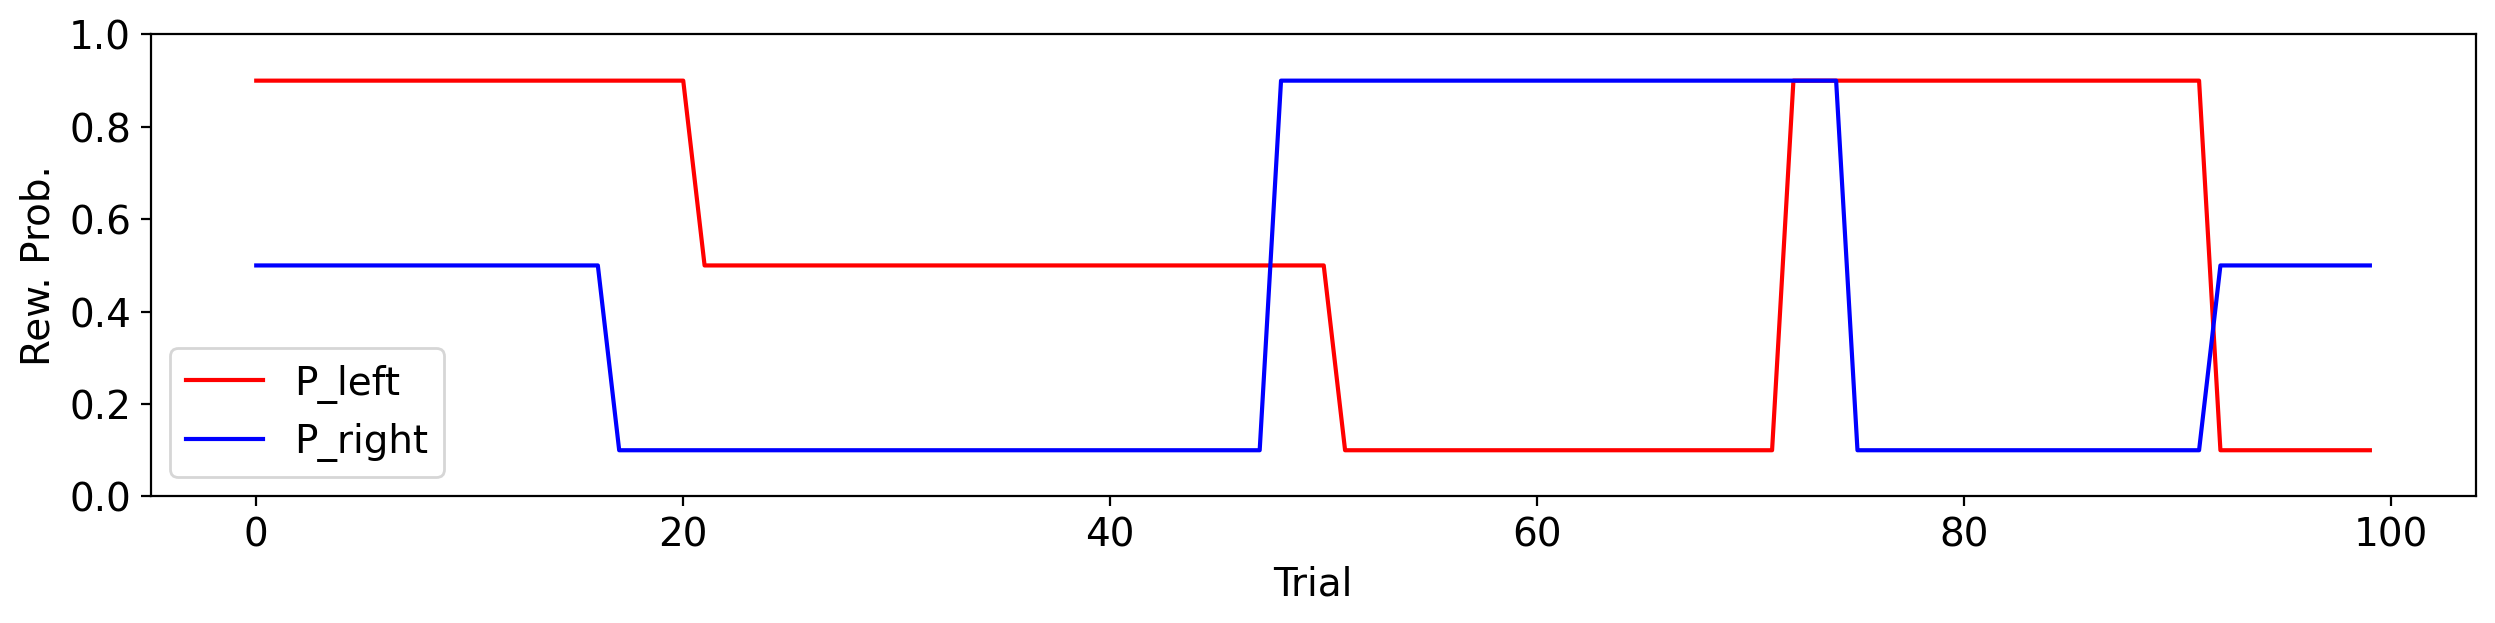

In [ ]:
# reward probabilities fluctuate over trials between [0.1, 0.5, 0.9]
print(np.unique(p_reward))
# visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=200)
ax.plot(task.get_p_reward()[0], label='P_left', color='red')
ax.plot(task.get_p_reward()[1], label='P_right', color='blue')
ax.set_ylim(0, 1)
ax.set_xlabel('Trial')
ax.set_ylabel('Rew. Prob.')
ax.legend()

#### Visualization of (un)rewarded choices

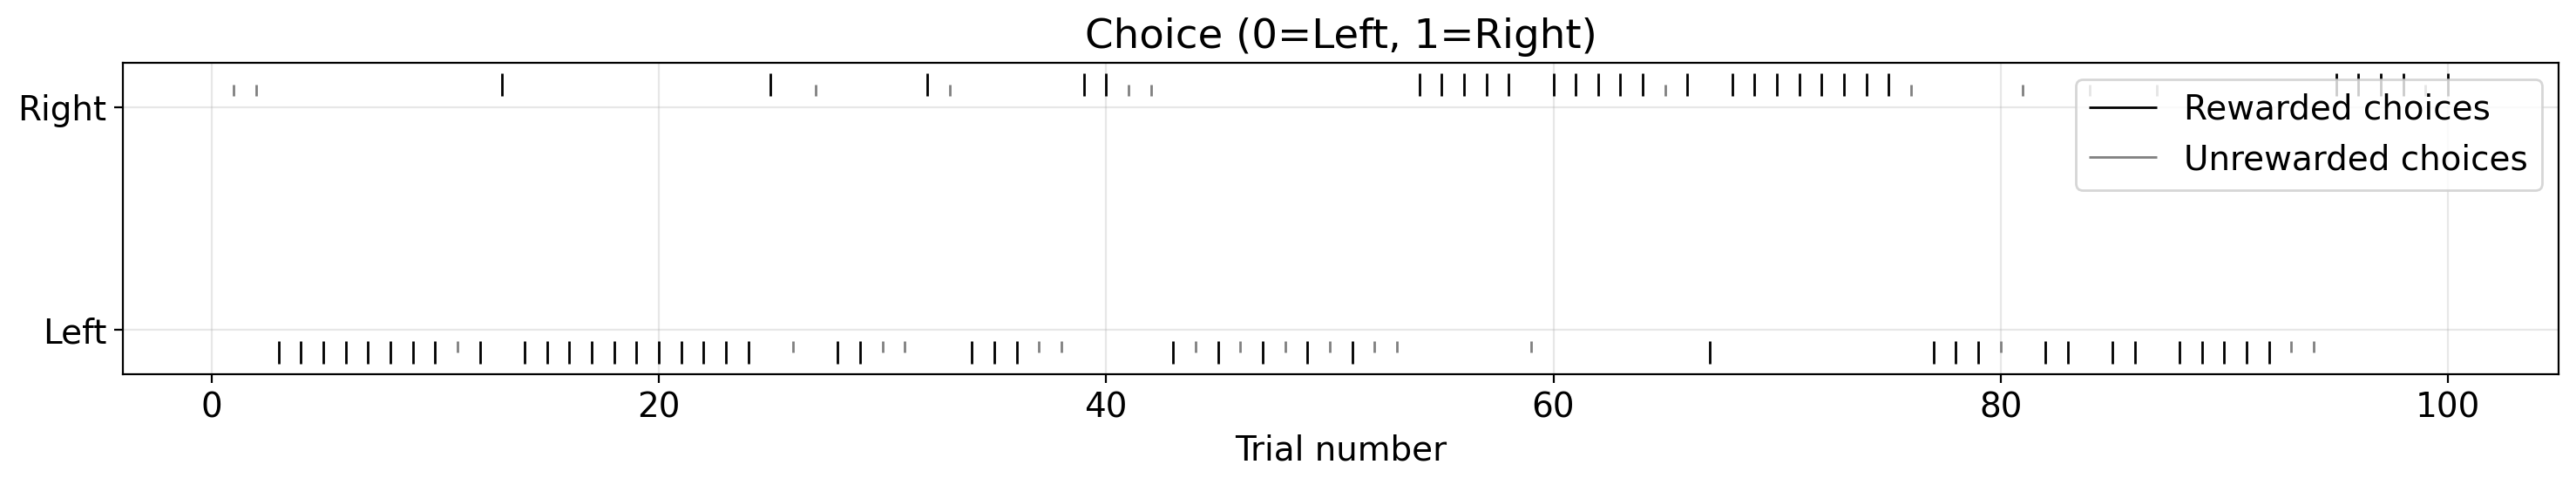

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=200)

rewarded_trials = reward_history == 1
unrewarded_trials = reward_history == 0
xx = np.nonzero(rewarded_trials)[0] + 1
yy_temp = choice_history[rewarded_trials]
yy_right = yy_temp[yy_temp > 0.5] + 0.05
xx_right = xx[yy_temp > 0.5]
yy_left = yy_temp[yy_temp < 0.5] - 0.05
xx_left = xx[yy_temp < 0.5]

# Rewarded choices
ax.vlines(xx_right, yy_right, yy_right + 0.1, alpha=1, linewidth=1, color="black", label="Rewarded choices")
ax.vlines(xx_left, yy_left - 0.1, yy_left, alpha=1, linewidth=1, color="black")

unrewarded_trials = reward_history == 0
xx = np.nonzero(unrewarded_trials)[0] + 1
yy_temp = choice_history[unrewarded_trials]
yy_right = yy_temp[yy_temp > 0.5]
xx_right = xx[yy_temp > 0.5]
yy_left = yy_temp[yy_temp < 0.5]
xx_left = xx[yy_temp < 0.5]

# Unrewarded choices
ax.vlines(xx_right, yy_right + 0.05, yy_right + 0.1, alpha=1, linewidth=1, color="gray", label="Unrewarded choices")
ax.vlines(xx_left, yy_left - 0.1, yy_left - 0.05, alpha=1, linewidth=1, color="gray")

# Set up axis labels and limits
ax.set_xlabel('Trial number')
ax.set_ylim(-0.2, 1.2)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Left', 'Right'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.title('Choice (0=Left, 1=Right)')
plt.tight_layout()
plt.show()

#### Visualization of choice statistics
1. Base reward probabilities = p_right / (p_right + p_left)
2. Choice = moving average of choice history, i.e. moving average of choosing right 
3. Q(L) (`ground_truth_q_value[0,:]`): ground truth q value for left choice
4. Q(R) (`ground_truth_q_value[1,:]`): ground truth q value for right choice
5. choice_prob(R/R+L) (`ground_truth_choice_prob[1] / ground_truth_choice_prob.sum(axis=0)`): choice probability normalized

Question: why are Q values fluctuctuating?

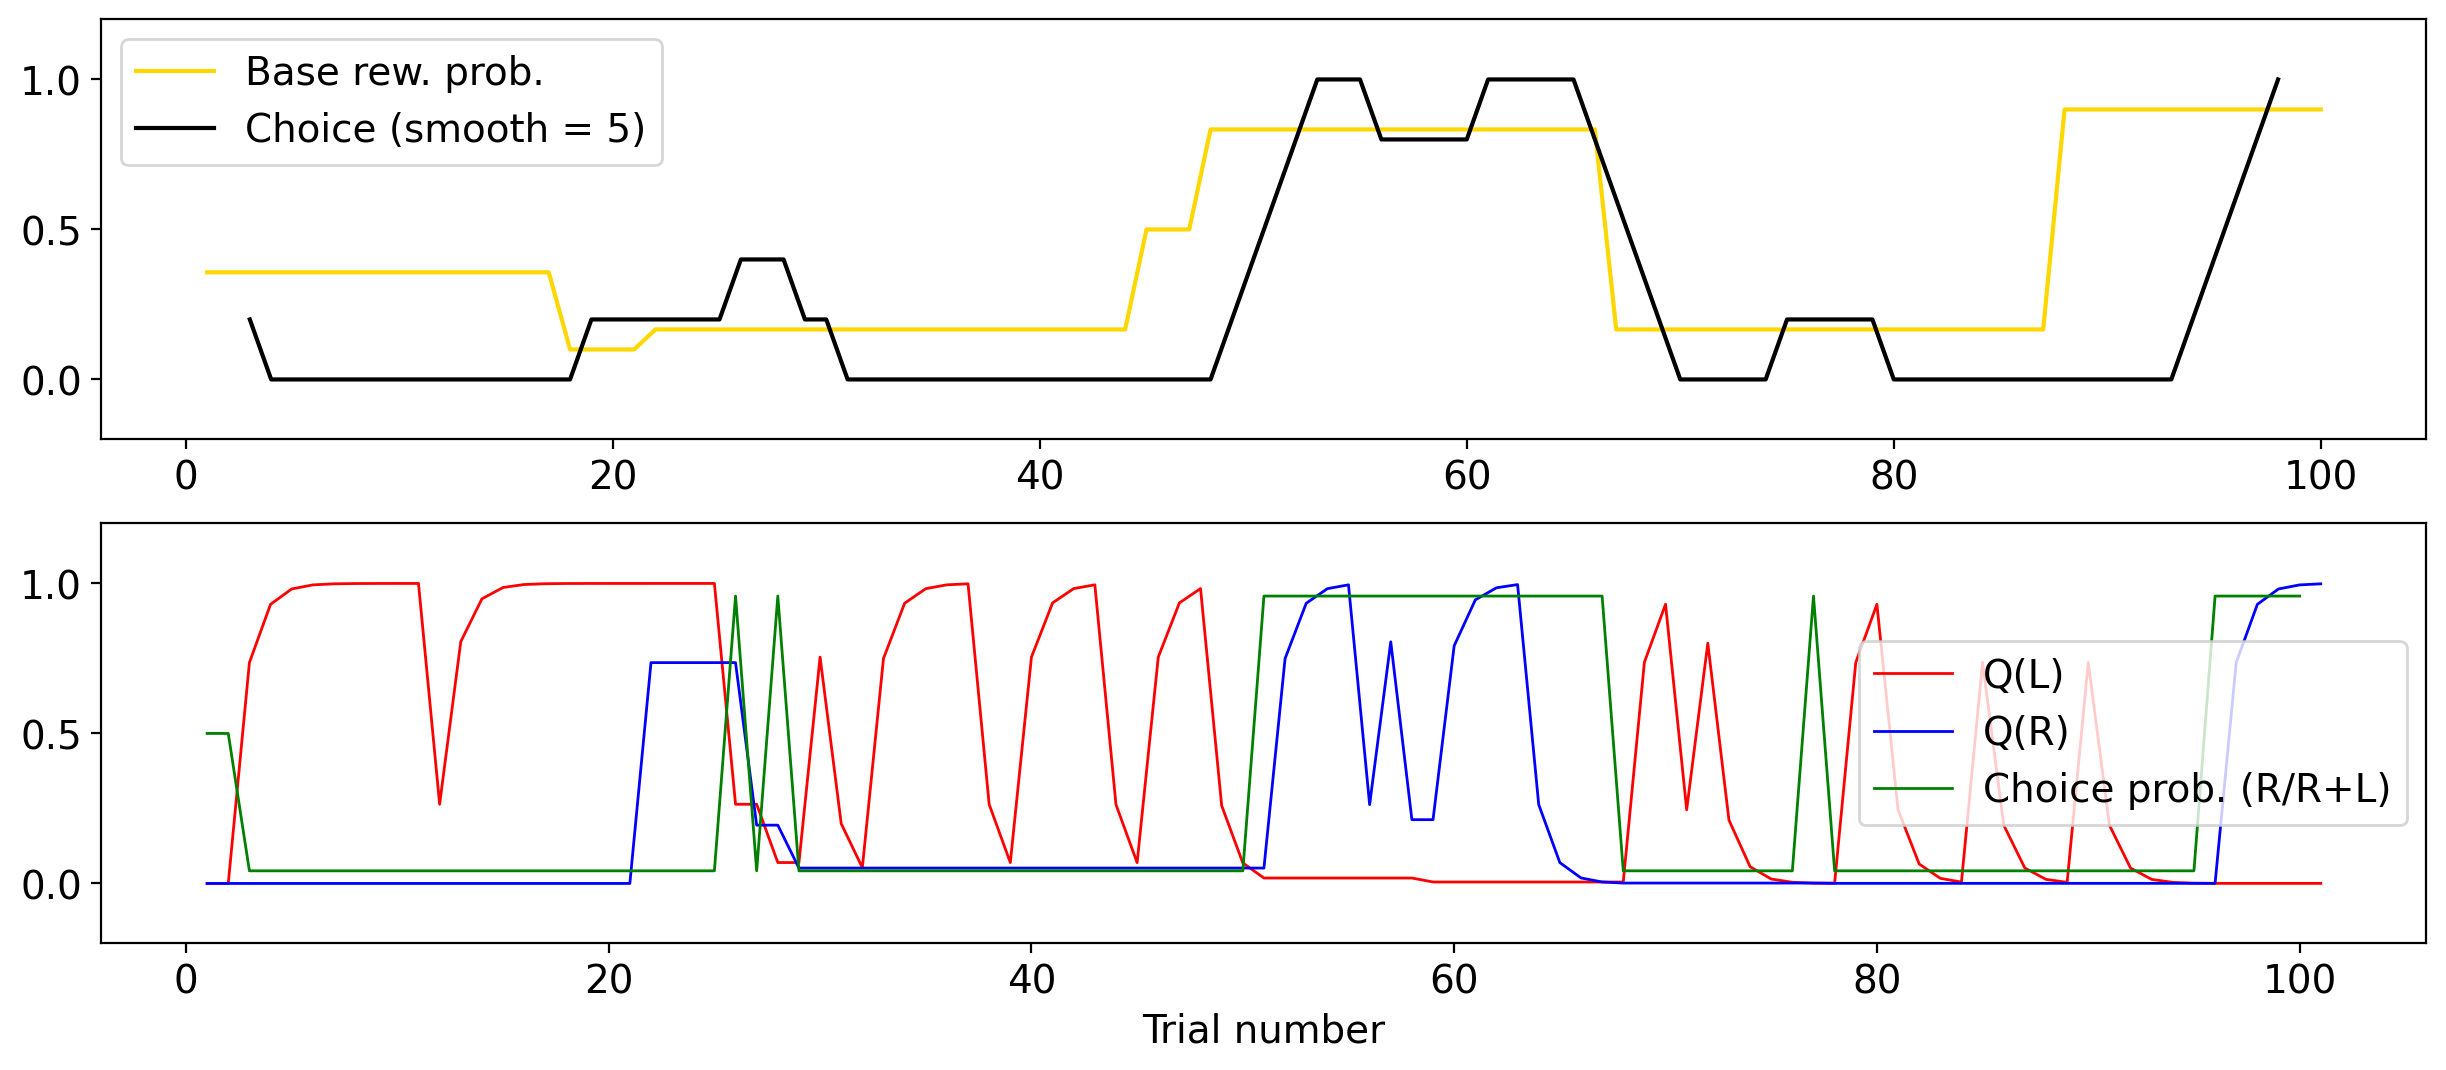

In [120]:
fig, axs = plt.subplots(2, 1, figsize=(15, 6), dpi=200)

def moving_average(a, n=3):
    """Compute moving average of a list or array."""
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[(n - 1):] / n

n_trials = len(choice_history)
smooth_factor = 5  

ax = axs[0]
ax.plot(np.arange(1,n_trials+1), p_reward[1, :] / (np.sum(p_reward, axis=0)),
         color="gold",label="Base rew. prob.",lw=1.5,)
y = moving_average(choice_history, n=smooth_factor)
ax.plot(np.arange(0, len(y)) + int(smooth_factor / 2) + 1, y,
        linewidth=1.5,color="black",label="Choice (smooth = %g)" % smooth_factor)
ax = axs[1]
ax.plot(np.arange(1,n_trials+2), ground_truth_q_value[0, :], lw=1, color="red", ls="-", label="Q(L)")
ax.plot(np.arange(1,n_trials+2), ground_truth_q_value[1, :], lw=1, color="blue", ls="-", label="Q(R)")
ax.plot(np.arange(1,n_trials+1), ground_truth_choice_prob[1] / np.sum(ground_truth_choice_prob, axis=0), lw=1, color="green", ls="-", label="Choice prob. (R/R+L)")

axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('Trial number')
axs[0].set_ylim(-0.2, 1.2)
axs[1].set_ylim(-0.2, 1.2)
plt.show()

#### Visualization on one plot

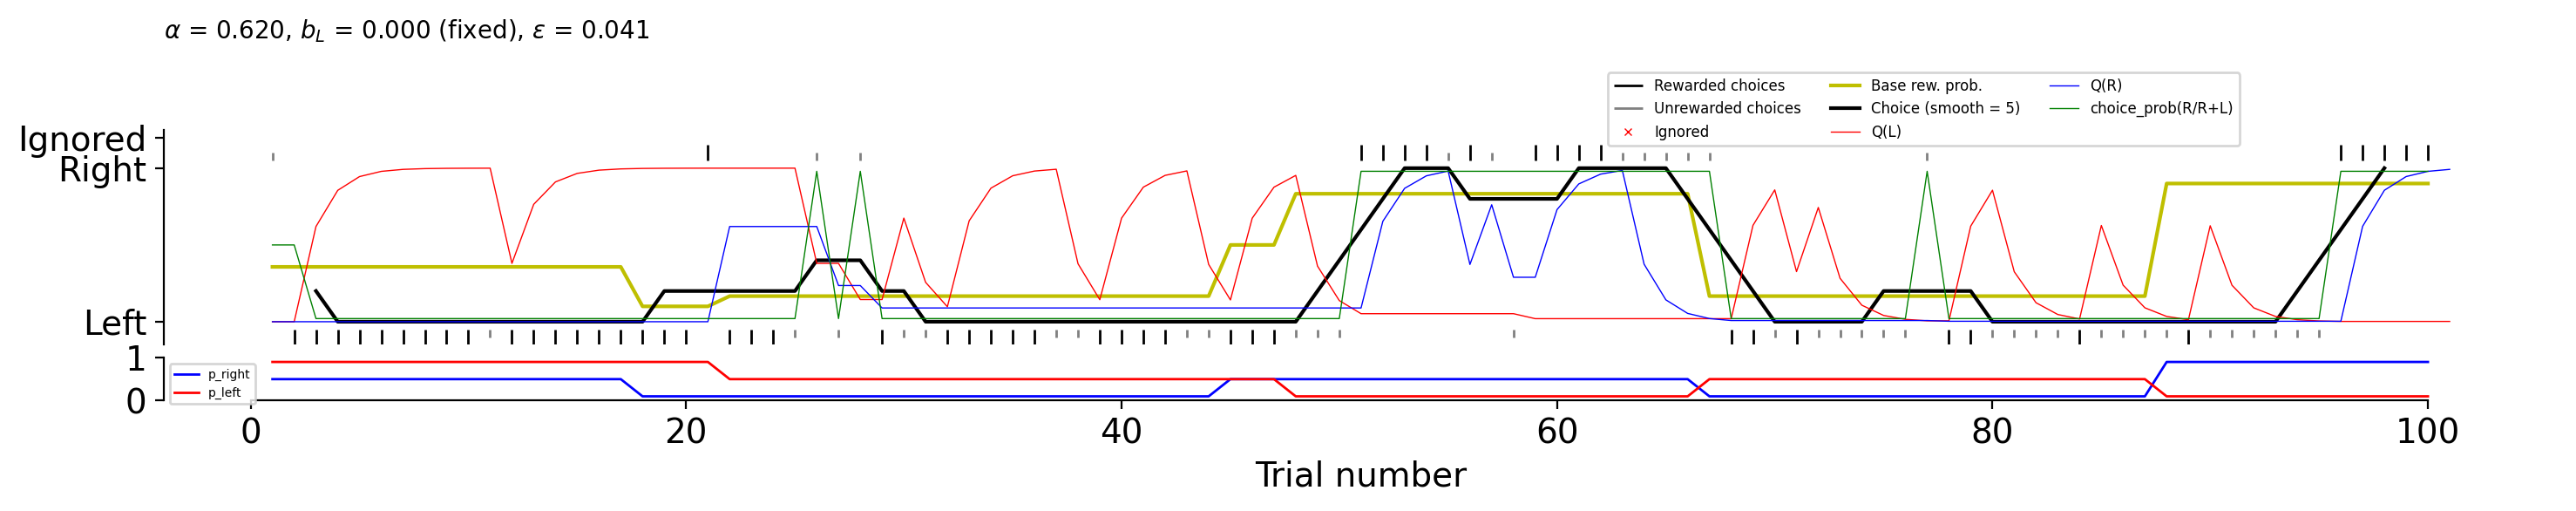

In [108]:
fig, axes = forager.plot_session(if_plot_latent=True)

## Parameter Recovery
Now we have access to the simulated agent's choices and environment feedback. How can we obtain the agent's latent belief, which govern its choices from Q-learing model? We could utilize the `fit` function associated with `forager` class. 

<details>
<summary><b> forager.fit() explained </b></summary>

**Main purpose** 

Finds the model parameters that maximize the likelihood of observing the actual choice and reward history. Computes model evaluation metrics (AIC, BIC, prediction accuracy). Optionally cross-validation.

**Inputs** 
- `fit_choice_history` / `fit_reward_history`: Behavioral data to fit
- `clamp_params`: Fix specific parameters (e.g., `{"biasL": 0}`)
- `fit_bounds_override`: Custom parameter bounds for fitting
- `k_fold_cross_validation`: Number of CV folds (None = no CV)
- `DE_kwargs`: Optimization settings (workers, seed, etc.)

**Outputs**
- `fitting_result`: Best parameters, likelihood, AIC/BIC, prediction accuracy
- `fitting_result_cross_validaiton` (if requested): Test accuracies across folds


</details>


In [101]:
forager.fit(
    choice_history,
    reward_history,
    clamp_params={"biasL": 0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager.fitting_result

2025-07-21 14:43:05,061 - utils_model_recovery - INFO - Fitting the model using the whole dataset...
2025-07-21 14:43:05,061 - utils_model_recovery - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 11.185005096442376
differential_evolution step 2: f(x)= 11.152381902721087
differential_evolution step 3: f(x)= 11.152381902721087
differential_evolution step 4: f(x)= 11.149756842084898
differential_evolution step 5: f(x)= 11.149756842084898
differential_evolution step 6: f(x)= 11.14954060949086
differential_evolution step 7: f(x)= 11.149405060597891
differential_evolution step 8: f(x)= 11.149405060597891
differential_evolution step 9: f(x)= 11.149405060597891
Polishing solution with 'L-BFGS-B'


In [121]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

Num of trials: 100
Fitted parameters: ['learn_rate', 'epsilon']
Ground truth: ['0.7360', '0.0841']
Fitted:       ['0.6200', '0.0408']
Likelihood-Per-Trial: 0.8944968788671388
Prediction accuracy full dataset: 0.97



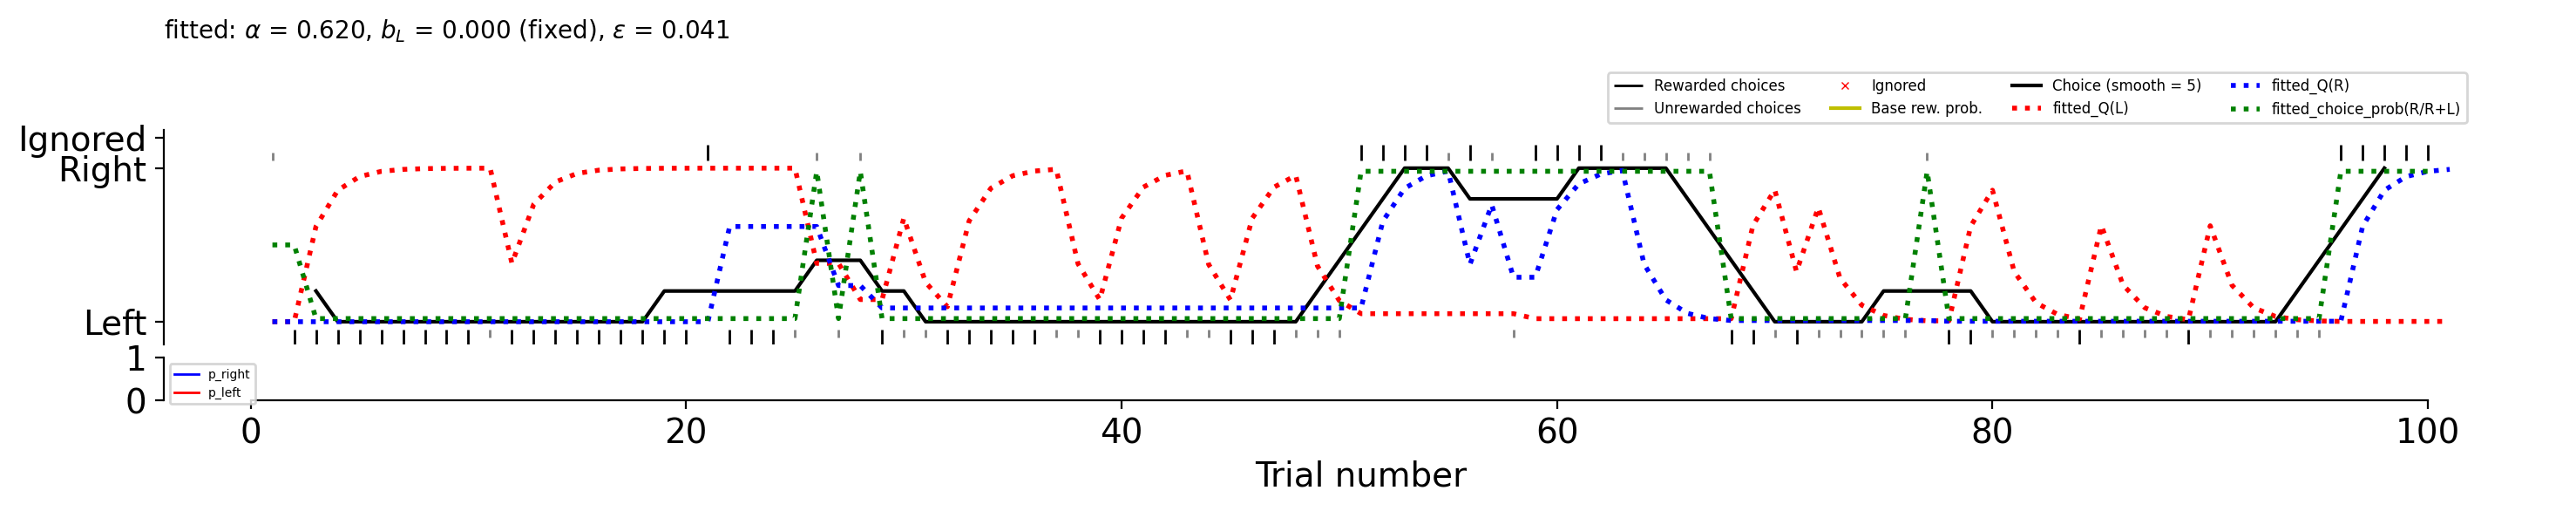

In [125]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

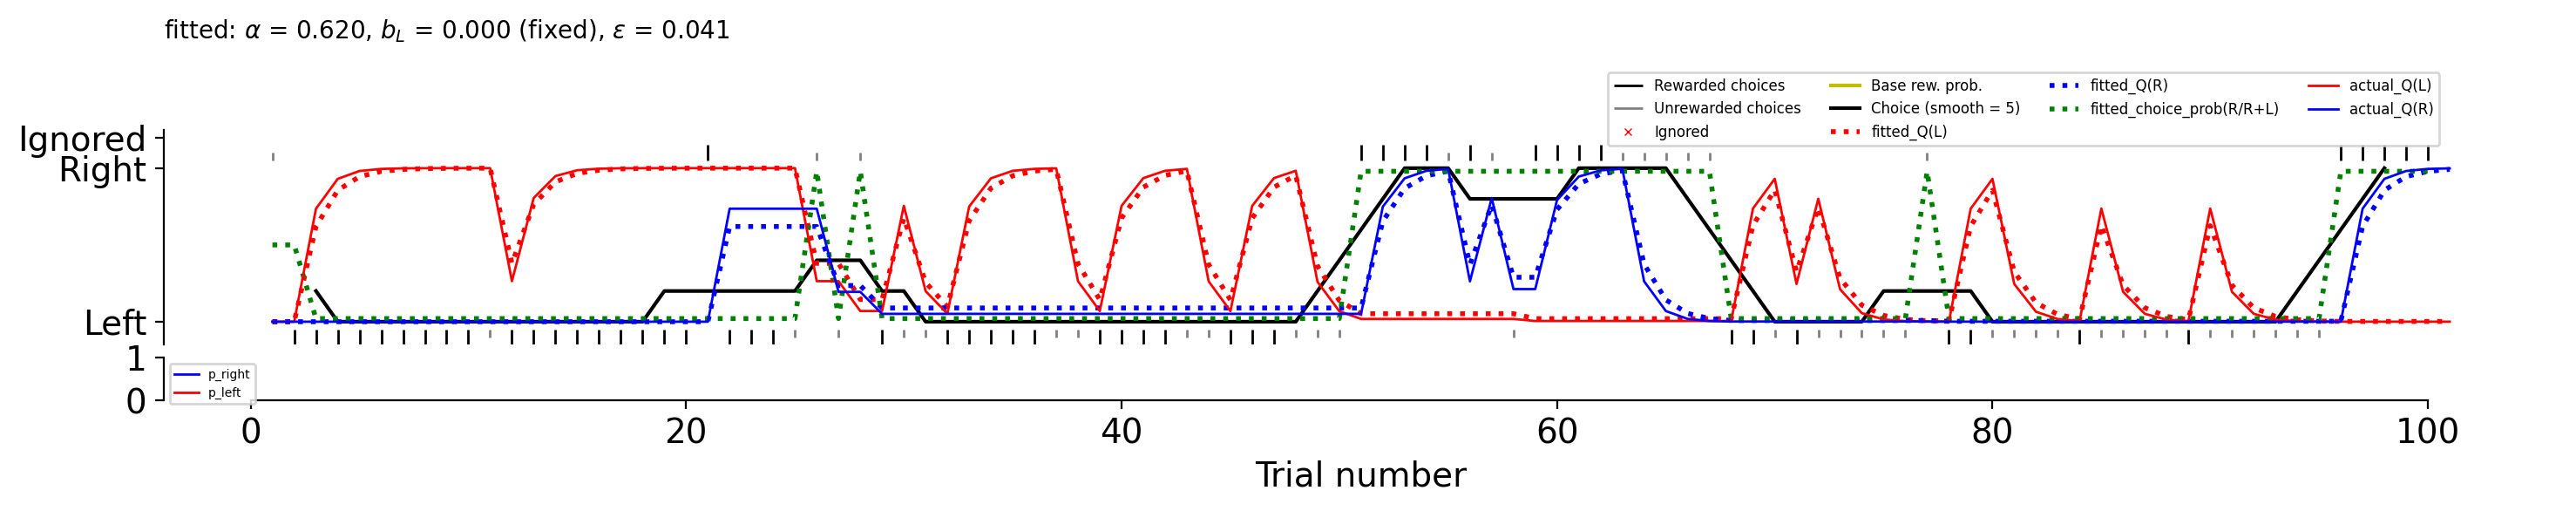

In [126]:
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)
xx = np.arange(1, len(ground_truth_q_value[0]) + 1)
axes[0].plot(xx, ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(xx, ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)

**Question**: Why the inferred learning rate/epsilon don't match ground truth but the fitted latent variables still look the same? 

## Task simulation: dynamic foraging + win-stay-lose-shift


The win-stay-lose-shift model is one of the simplest models that adapts its behavior according to feedback. Consistent with the name, the model repeats rewarded actions and switches away from unrewarded actions.

In the noisy version of the model, the win-stay-lose-shift rule is applied probabilistically, such that the model applies the win-stay-lose-shift rule with probability $1−\epsilon$, and chooses randomly with probability $\epsilon$. In the two-bandit case, the probability of choosing option k is: 

Let $c_t \in \{1, 2\}$ be the choice at trial $t$, and $r_t \in \{0, 1\}$ the reward at trial $t$. Then:

$$
p_k^t = 
\begin{cases}
1 - \frac{\epsilon}{2} & \text{if } (c_{t-1} = k \land r_{t-1} = 1) \text{ or } (c_{t-1} \neq  k \land r_{t-1} = 0) \\
\frac{\epsilon}{2} & \text{if } (c_{t-1} \not = k \land r_{t-1} = 1) \text{ or } (c_{t-1} = k \land r_{t-1} = 0)
\end{cases}
$$

Although more complex to implement, this model still only has one free parameter, the overall level of randomness, $ \theta_2 = \epsilon $.

**Question:**

Why is the probability $1-\frac{\epsilon}{2}$?

<details>
<summary><b> Answer </b></summary>

- On each trial, the agent applies the win-stay-lose-shift rule with probability $1-\epsilon$.
    - If applying the rule:  
        - **Win (rewarded):** repeat previous choice  
        - **Loss (unrewarded):** switch to the other choice  
- With probability $\epsilon$, the agent ignores the rule and chooses randomly:
    - Each option has probability $0.5$.

**List all outcomes:**

| Previous Choice | Previous Reward | Probability of Choosing $k$ at $t$ |
|-----------------|----------------|------------------------------------|
| $c_{t-1} = k$   | $r_{t-1} = 1$  | $1-\epsilon + \frac{\epsilon}{2}$  |
| $c_{t-1} = k$   | $r_{t-1} = 0$  | $\frac{\epsilon}{2}$               |
| $c_{t-1} \neq k$| $r_{t-1} = 1$  | $\frac{\epsilon}{2}$               |
| $c_{t-1} \neq k$| $r_{t-1} = 0$  | $1-\epsilon + \frac{\epsilon}{2}$  |



</details>

Now let's initialize an artificial agent with noisy 'win-stay-lose-shift' algorithm with `ForagerLossCounting` class

In [129]:
# initialize the task
task = UncoupledBlockTask(reward_baiting=True, num_trials=100, seed=42)
# initialize the forager with noisy 'win-stay-lose-shift' algorithm
forager = ForagerLossCounting(win_stay_lose_switch=True, choice_kernel='none')
# set some parameters
forager.set_params(biasL = 0.3)


{'loss_count_threshold_mean': 1.0,
 'loss_count_threshold_std': 0.0,
 'biasL': 0.3}

{'loss_count_threshold_mean': 1.0, 'loss_count_threshold_std': 0.0, 'biasL': 0.3}


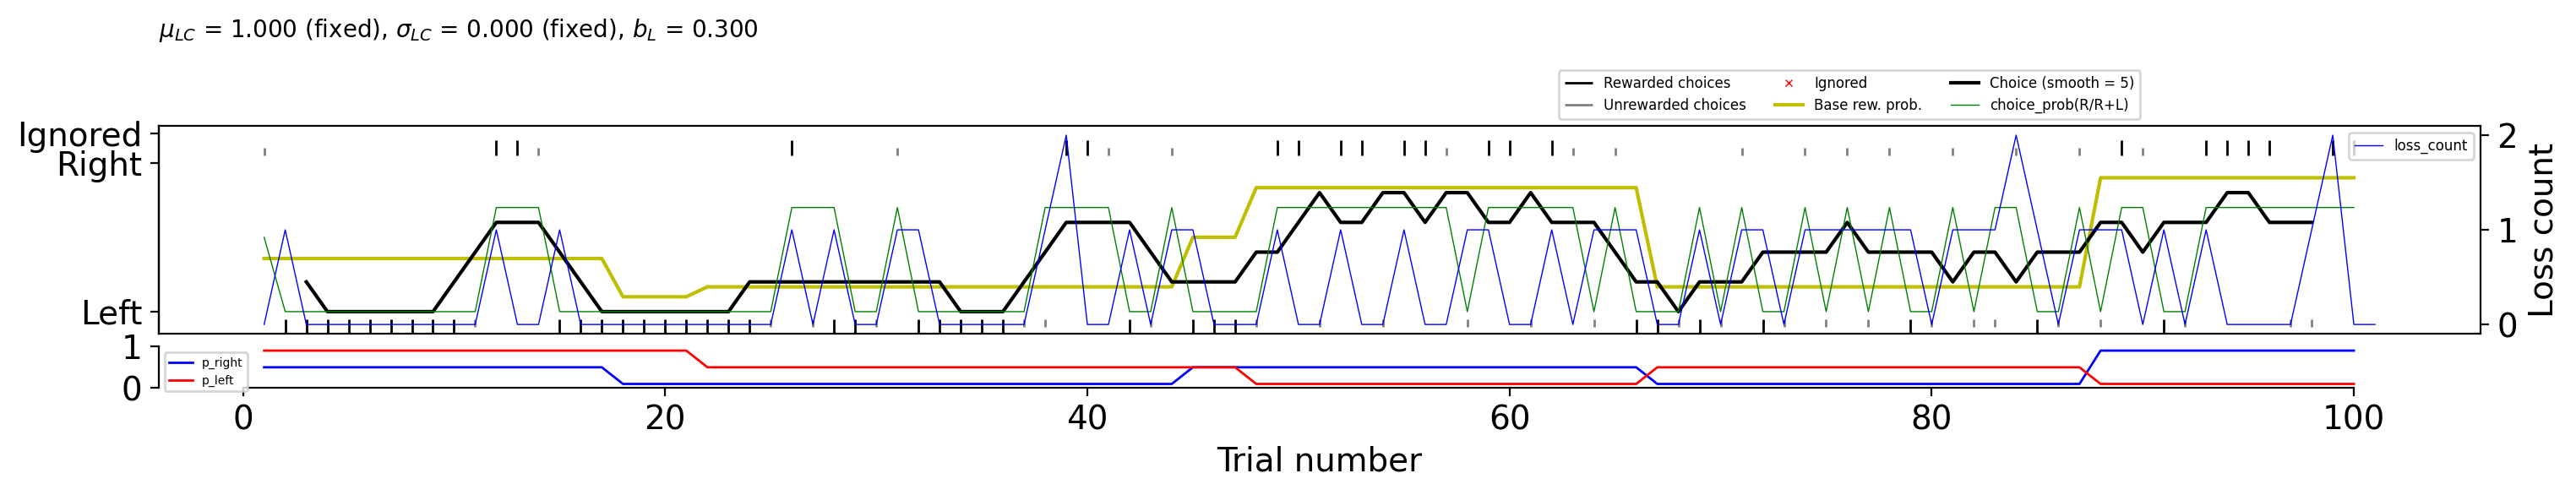

In [130]:
forager.perform(task)

# Capture the results
ground_truth_params = forager.params.model_dump()
print(ground_truth_params)

ground_truth_loss_count = forager.loss_count
ground_truth_choice_prob = forager.choice_prob

# Get the history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()

# Plot the session results
fig, axes = forager.plot_session(if_plot_latent=True)

In [10]:
# Fit the model to recover parameters
forager.fit(
    choice_history,
    reward_history,
    # fit_bounds_override={"softmax_inverse_temperature": [0, 100]},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager.fitting_result

2025-07-15 21:20:08,438 - utils_model_recovery - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 266.6756735312347
differential_evolution step 2: f(x)= 266.6756735312347
differential_evolution step 3: f(x)= 266.59023869974754
differential_evolution step 4: f(x)= 266.59023869974754
differential_evolution step 5: f(x)= 266.59023869974754
differential_evolution step 6: f(x)= 266.5885299313018
Polishing solution with 'L-BFGS-B'


In [11]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
print(fit_names)
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

['biasL']
Num of trials: 1000
Fitted parameters: ['biasL']
Ground truth: ['0.3000']
Fitted:       ['0.3056']
Likelihood-Per-Trial: 0.765988283443836
Prediction accuracy full dataset: 0.867



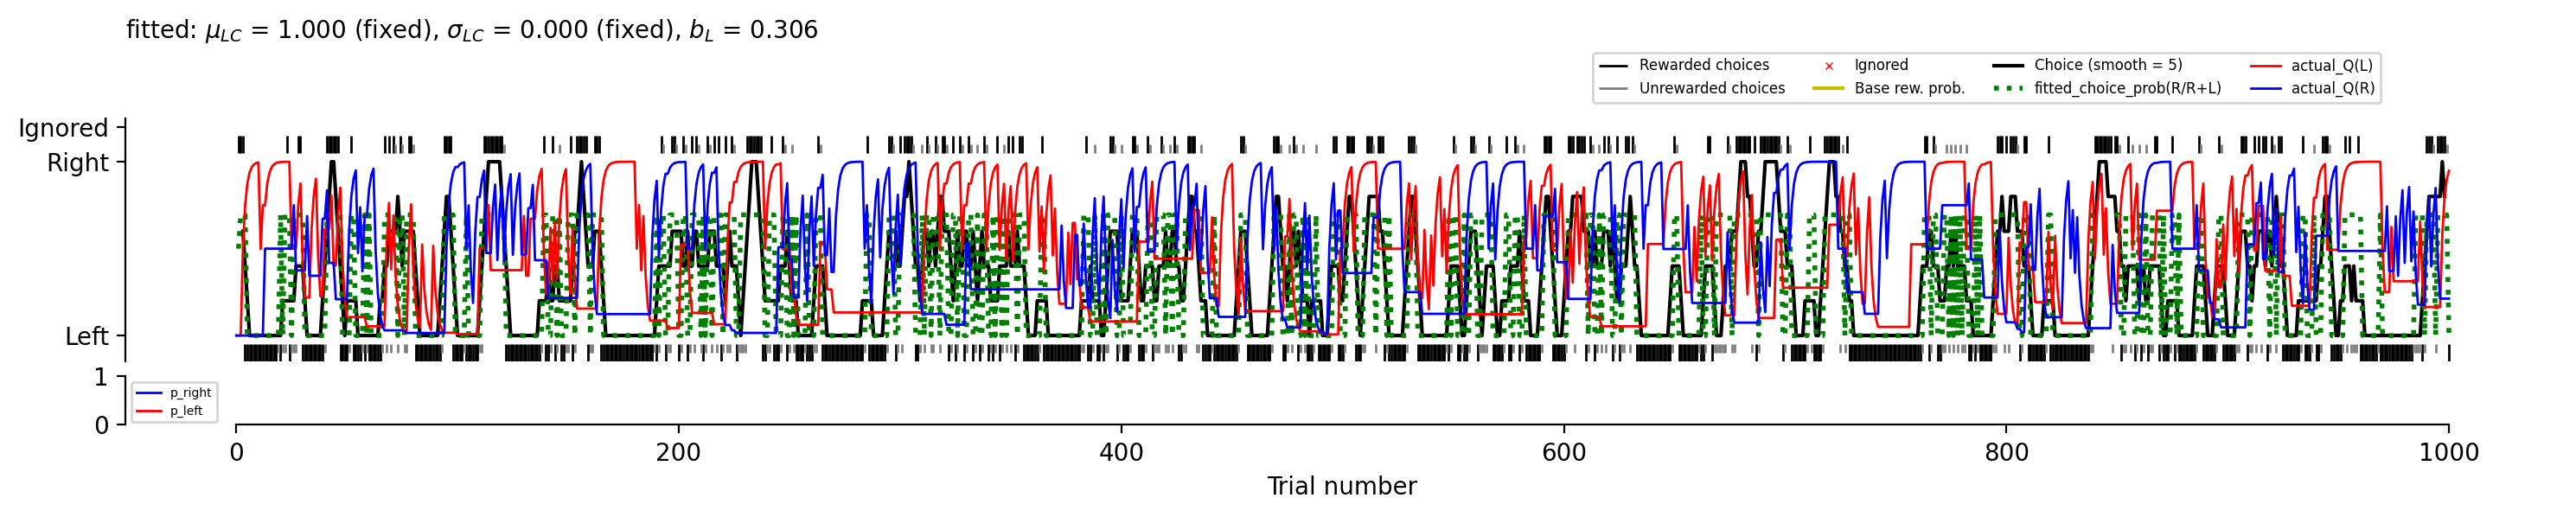

In [12]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

# Overlay the ground truth Q-values for comparison
axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)

In [24]:
n_trials = 1000

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[30,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,0]], n_models = 30, method = 'random_uniform')

fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'DE', pool = pool);    

[autoreload of utils_model_recovery failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/root/capsule/code/utils_model_recovery.py", line 4713, in <module>
    import seaborn as sns
ModuleNotFoundError: No module named 'seaborn'
]


NameError: name 'generate_true_paras' is not defined

# Testing on Han's model comparison code

In [8]:
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt

n_worker = int(mp.cpu_count()/2)
pool = mp.Pool(processes = n_worker)
    
from utils_model_recovery import *

# n_trials = 400 # 

# forager = 'LossCounting'
# para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
# para_bounds = [[0,0],[30,10]]

# # Para recovery
# true_paras = generate_true_paras(para_bounds=[[0,0],[30,0]], n_models = 30, method = 'random_uniform')

# fit_para_recovery(forager = forager, 
#                   para_names = para_names, para_bounds = para_bounds, 
#                   true_paras = true_paras, n_trials = n_trials, 
#                   fit_method = 'DE', pool = pool);    


Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-1:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File 

Fitting using L-BFGS-B (n_x0s = 8), pool = False...
  True para: [10  4]
Fitted para: [17.294  6.106]
km = 2, AIC = 385.72, BIC = 395.538
      LPT_AIC = 0.825, LPT_BIC = 0.821
the shape of x is  (997,)
the shape of y is  (997,)


/root/capsule/code/utils_model_recovery.py:5033: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k|" (-> color='k'). The keyword argument will take precedence.
  ax.plot(np.nonzero(rewarded_trials)[0], 0.5 + (choice_history[0,rewarded_trials]-0.5) * 1.4,


ValueError: x and y must have same first dimension, but have shapes (1001,) and (1002,)

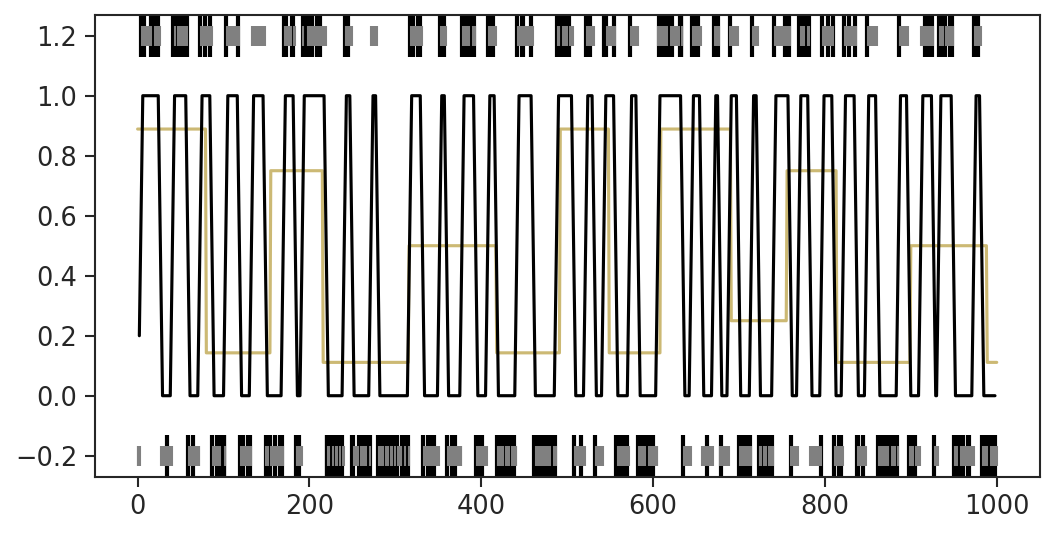

Process ForkPoolWorker-21:
Process ForkPoolWorker-20:
Process ForkPoolWorker-16:
Process ForkPoolWorker-19:
Process ForkPoolWorker-9:
Process ForkPoolWorker-22:
Process ForkPoolWorker-17:
Process ForkPoolWorker-14:
Process ForkPoolWorker-24:
Process ForkPoolWorker-10:
Process ForkPoolWorker-18:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Process ForkPoolWorker-15:
Process ForkPoolWorker-23:
Traceback (most recent call last):
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/

In [9]:
n_trials = 1000
forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

true_para = [10,4]

# LL_surface
compute_LL_surface(forager, para_names, para_bounds,
                   true_para = true_para, n_trials = n_trials,
                   fit_method = 'L-BFGS-B', n_x0s = 8, pool = '');

# demonstrate parameter recovery on Loss Counting 

Parameter Recovery, LossCounting: 100%|██████████| 25/25 [08:04<00:00, 19.37s/it]
/root/capsule/code/utils_model_recovery.py:4909: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(true_paras[para_2d[0],n], true_paras[para_2d[1],n],'ok', markersize=11, fillstyle='none', c = colors[n], label = 'True' if not legend_plotted else '',alpha=.7)
/root/capsule/code/utils_model_recovery.py:4910: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(fitted_paras[para_2d[0],n], fitted_paras[para_2d[1],n],'ok', markersize=7, c = colors[n], label = 'Fitted' if not legend_plotted else '',alpha=.7)


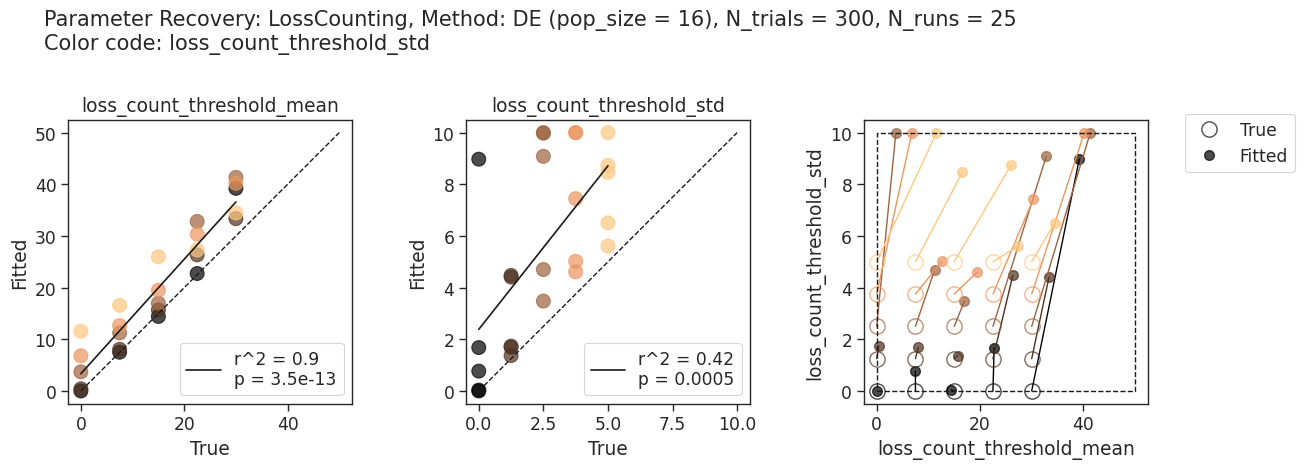

In [11]:
n_trials = 300

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,5]], n_models = [5,5], method = 'linspace')

fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'DE', pool = pool);    

# Parameter Recovery on RW rule - similar to Wilson and Collins 2019

In [14]:
n_trials = 300

forager = 'RW1972_softmax'
para_names = ['learn_rate_rew','softmax_temperature','biasL']
para_scales = ['linear','log','linear']
para_bounds = [[0,1e-2,-10],
               [1, 15, 10]]

n_models = 30
true_paras = np.vstack((np.random.uniform(0, 1, size = n_models),
                        1/np.random.exponential(10, size = n_models),
                        np.random.uniform(-5, 5, size = n_models))) # Inspired by Wilson 2019. I found beta ~ Exp(10) would be better

true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 2, para_2ds = [[0,1],[0,2],[1,2]],
              fit_method = 'DE', pool = pool); 

Parameter Recovery, RW1972_softmax:   0%|          | 0/30 [00:00<?, ?it/s]


None


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.9/multiprocessing/pool.py", line 692, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/opt/conda/lib/python3.9/multiprocessing/pool.py", line 672, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt: 


AssertionError: 

# Demonstrate model recovery

=== Model Comparison ===
Methods = DE, {'DE_pop_size': 16}, pool = True
Model 1/8:    LossCounting, Km = 2 ... AIC = 5.38629, BIC = 15.2038 (done in 102 secs)
Model 2/8:     RW1972_epsi, Km = 2 ...0.4250582331492350.8901423366137263

0.60096726515385050.68450504083520640.259066093543197260.65493812392220170.137142635422850430.49406989188982090.73057847651490470.287742888142904330.86457393269882990.119769108150042940.016977981645768803

0.06033958035958653





0.8317977085891892

0.31637149787128216



0.79397221306443020.35948052154102683
0.57601464784021570.71824173916380060.5132529698376341
0.24396544809420030.5525988510546768



0.94752009295426380.08100418937131570.18347959793282498
0.20240231173700118


0.9243205744969581
0.396936174290365930.76165961349351870.9990689538978503



0.45747052771953806
0.58238695160904740.4250582331492350.386738252304960840.98222895022854580.26792499257761070.82612358678863210.0169779816457688030.10757495308307807
0.336528046371959650.43447030700951

/root/capsule/code/utils_model_recovery.py:5034: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k|" (-> color='k'). The keyword argument will take precedence.
  ax.plot(np.nonzero(rewarded_trials)[0], 0.5 + (choice_history[0,rewarded_trials]-0.5) * 1.4,


IndexError: list index out of range

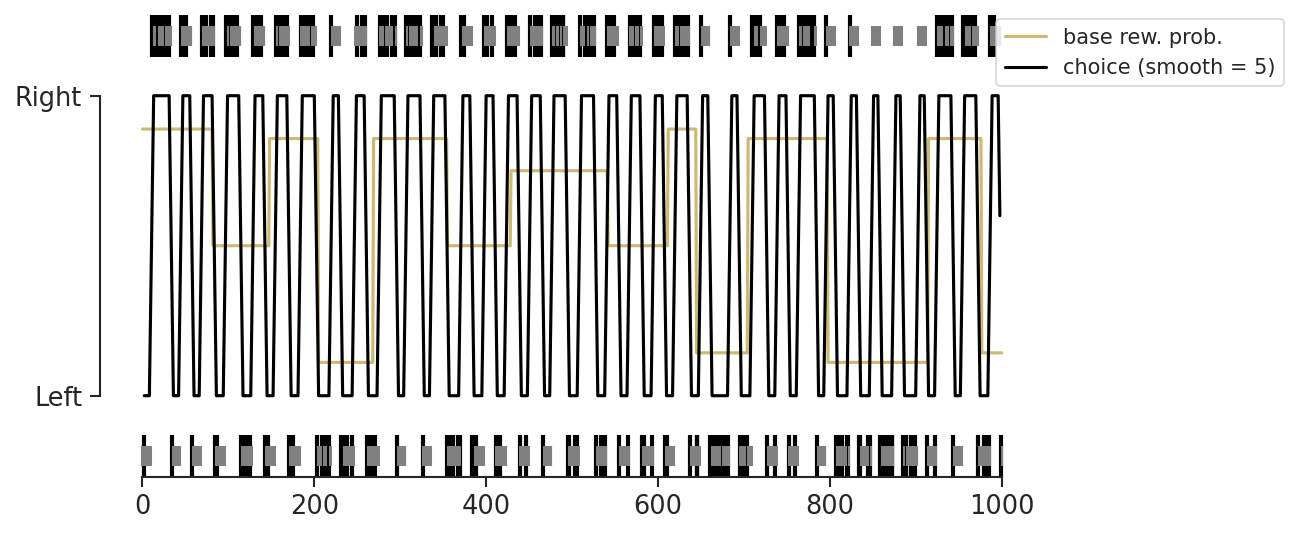

In [16]:
choice_history, reward_history, p_reward = generate_fake_data('LossCounting', ['loss_count_threshold_mean','loss_count_threshold_std'], [10,0])
model_comparison = BanditModelComparison(choice_history, reward_history, p_reward, models = [1,2,3,4,5,6,7,8])
model_comparison.fit(pool = pool, plot_predictive=[1,2,3])  # Plot predictive traces for the 1st, 2nd, and 3rd models
model_comparison.show()
model_comparison.plot()

In [21]:
model_comparison.results_sort

,model,Km,AIC,BIC,LPT_AIC,LPT_BIC,LPT,para_names,para_bounds,para_notation,para_fitted,relative_likelihood_AIC,relative_likelihood_BIC,model_weight_AIC,model_weight_BIC,log10_BF_AIC,log10_BF_BIC,best_model_AIC,best_model_BIC
1,LossCounting,2,5.386294,15.203804,0.997313,0.992434,0.999308,"[loss_count_threshold_mean, loss_count_thresho...","[[0, 0], [40, 10]]","$\mu_{LC}$, $\sigma_{LC}$","[9.776, 0.026]",1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-0.000000,-0.000000,1,1
8,Hattori2019,4,493.326175,512.961194,0.781596,0.773968,0.784726,"[learn_rate_rew, learn_rate_unrew, forget_rate...","[[0, 0, 0, 0.01], [1, 1, 1, 15]]","$\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\si...","[1.0, 0.132, 1.0, 0.264]",1.109689e-106,8.191362e-109,1.109689e-106,8.191362e-109,-105.954799,-108.086644,0,0
3,LNP_softmax,2,659.556423,669.373933,0.719320,0.715801,0.720759,"[tau1, softmax_temperature]","[[0.001, 0.01], [100, 15]]","$\tau_1$, $\sigma$","[1.637, 0.091]",8.887127e-143,8.887127e-143,8.887127e-143,8.887127e-143,-142.051239,-142.051239,0,0
4,LNP_softmax,4,663.556423,683.191442,0.717884,0.710878,0.720759,"[tau1, tau2, w_tau1, softmax_temperature]","[[0.001, 0.1, 0, 0.01], [15, 40, 1, 15]]","$\tau_1$, $\tau_2$, $w_{\tau_1}$, $\sigma$","[1.637, 2.883, 1.0, 0.091]",1.202742e-143,8.878249e-146,1.202742e-143,8.878249e-146,-142.919828,-145.051673,0,0
7,Bari2019,3,673.399198,688.125463,0.714364,0.709128,0.716508,"[learn_rate, forget_rate, softmax_temperature]","[[0, 0, 0.01], [1, 1, 15]]","$\alpha$, $\delta$, $\sigma$","[0.05, 0.424, 0.01]",8.766798e-146,7.532141e-147,8.766798e-146,7.532141e-147,-145.057159,-146.123082,0,0
5,RW1972_softmax,2,965.265889,975.083399,0.617454,0.614433,0.618689,"[learn_rate, softmax_temperature]","[[0, 0.01], [1, 15]]","$\alpha$, $\sigma$","[0.96, 0.102]",3.671084e-209,3.671084e-209,3.671084e-209,3.671084e-209,-208.435206,-208.435206,0,0
6,Hattori2019,3,967.247986,981.974250,0.616843,0.612322,0.618694,"[learn_rate_rew, learn_rate_unrew, softmax_tem...","[[0, 0, 0.01], [1, 1, 15]]","$\alpha_{rew}$, $\alpha_{unr}$, $\sigma$","[1.0, 0.959, 0.107]",1.362660e-209,1.170752e-210,1.362660e-209,1.170752e-210,-208.865613,-209.931535,0,0
2,RW1972_epsi,2,1203.888030,1213.705539,0.548075,0.545394,0.549171,"[learn_rate, epsilon]","[[0, 0], [1, 1]]","$\alpha$, $\epsilon$","[0.591, 0.59]",5.606023e-261,5.606023e-261,5.606023e-261,5.606023e-261,-260.251345,-260.251345,0,0


In [22]:
model_comparison.plot_predictive

[1, 2, 3]

In [19]:
for bb in model_comparison.plot_predictive:
    print(bb)
    bb = bb - 1
    if bb < len(model_comparison.results):
        print(bb)
        this_id = model_comparison.results_sort.index[bb] - 1
        this_choice_prob = model_comparison.results_raw[this_id].predictive_choice_prob
        this_result = model_comparison.results_sort.iloc[bb]
        print(this_id, this_choice_prob, this_result)
        ax.plot(np.arange(0, n_trials), this_choice_prob[1,:] , linewidth = max(1.5-0.3*bb,0.2), 
                label = 'Model %g: %s, Km = %g\n%s\n%s' % (bb+1, this_result.model, this_result.Km, 
                                                                                    this_result.para_notation, this_result.para_fitted))


1
0


IndexError: list index out of range

,model,Km,AIC,log10_BF_AIC,model_weight_AIC,BIC,log10_BF_BIC,model_weight_BIC,para_notation,para_fitted
1,LossCounting,2,5.39,-0.00,1.0,15.20,-0.00,1.0,"$\mu_{LC}$, $\sigma_{LC}$","[9.776, 0.026]"
8,Hattori2019,4,493.33,-105.95,0.0,512.96,-108.09,0.0,"$\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\sigma$","[1.0, 0.132, 1.0, 0.264]"
3,LNP_softmax,2,659.56,-142.05,0.0,669.37,-142.05,0.0,"$\tau_1$, $\sigma$","[1.637, 0.091]"
4,LNP_softmax,4,663.56,-142.92,0.0,683.19,-145.05,0.0,"$\tau_1$, $\tau_2$, $w_{\tau_1}$, $\sigma$","[1.637, 2.883, 1.0, 0.091]"
7,Bari2019,3,673.40,-145.06,0.0,688.13,-146.12,0.0,"$\alpha$, $\delta$, $\sigma$","[0.05, 0.424, 0.01]"
5,RW1972_softmax,2,965.27,-208.44,0.0,975.08,-208.44,0.0,"$\alpha$, $\sigma$","[0.96, 0.102]"
6,Hattori2019,3,967.25,-208.87,0.0,981.97,-209.93,0.0,"$\alpha_{rew}$, $\alpha_{unr}$, $\sigma$","[1.0, 0.959, 0.107]"
2,RW1972_epsi,2,1203.89,-260.25,0.0,1213.71,-260.25,0.0,"$\alpha$, $\epsilon$","[0.591, 0.59]"


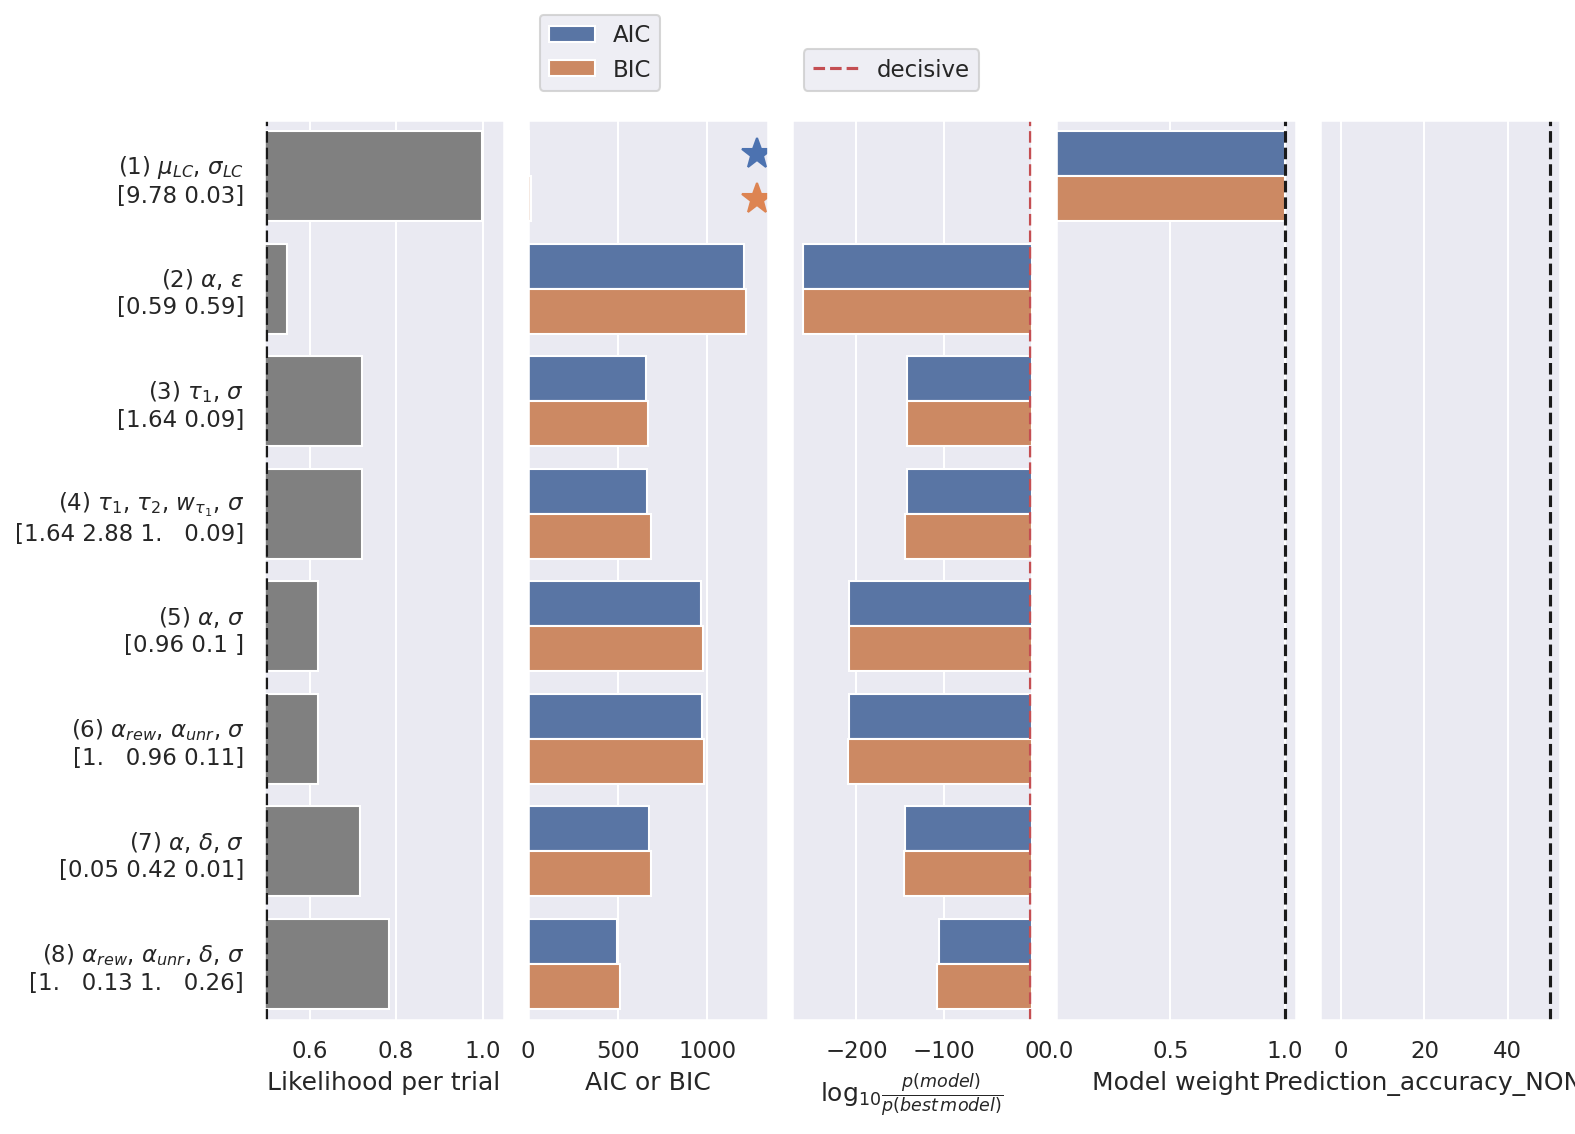

In [23]:
model_comparison.show()
model_comparison.plot()

0.3
=== Model Comparison ===
Methods = DE, {'DE_pop_size': 16}, pool = True
Model 1/8:    LossCounting, Km = 2 ... AIC = 1316.76, BIC = 1326.58 (done in 53.7 secs)
Model 2/8:     RW1972_epsi, Km = 2 ...0.65066972215270380.57011092181263010.03989183471562380.55314559982329030.37508860716148120.84587491844828280.68369004657099640.94879684667072770.91362036928919640.7107688705961990.371148220571959230.15008604067335451

0.97744499066504280.24254201694386845
0.34129629572934866









0.4219708355434527


0.091301806240196460.61651368119177160.17611811006289552

0.77016623231304450.256151481139796470.44425366995416140.109818056423550860.010006030109000585

0.4915821199168171


0.7398846236165091
0.82934645670068930.28253618268301130.505463333935098
0.216871572828977950.8951600882175654

0.7814315040366848




0.23070573652027250.264938070588840450.230017749377133540.173319096833661650.92032775391927790.60926962948974930.57299210144185820.37508860716148120.71968899351872380.19638960090363

/root/capsule/code/utils_model_recovery.py:5034: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k|" (-> color='k'). The keyword argument will take precedence.
  ax.plot(np.nonzero(rewarded_trials)[0], 0.5 + (choice_history[0,rewarded_trials]-0.5) * 1.4,


IndexError: list index out of range

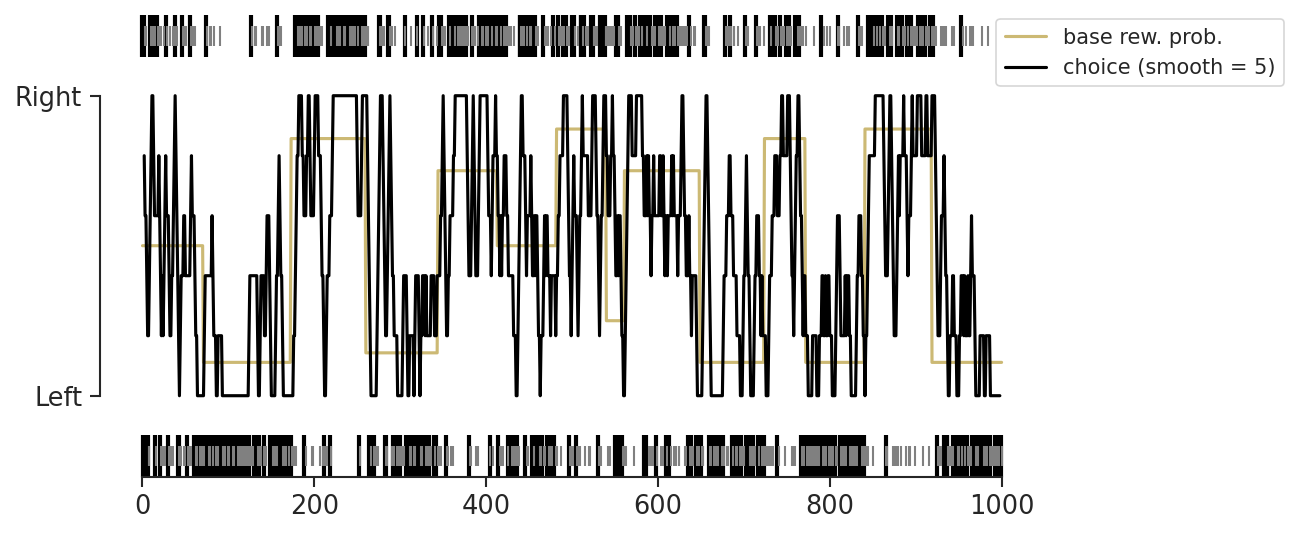

In [28]:
choice_history, reward_history, p_reward = generate_fake_data('RW1972_softmax', ['learn_rate','softmax_temperature'], [0.3,0.2])
model_comparison = BanditModelComparison(choice_history, reward_history, p_reward, models = [1,2,3,4,5,6,7,8])
model_comparison.fit(pool = pool, plot_predictive=[1,2,3]) # Plot predictive traces for the 1st, 2nd, and 3rd models
model_comparison.show()
model_comparison.plot()

,model,Km,AIC,log10_BF_AIC,model_weight_AIC,BIC,log10_BF_BIC,model_weight_BIC,para_notation,para_fitted
5,RW1972_softmax,2,977.08,-0.00,0.51,986.90,-0.00,0.93,"$\alpha$, $\sigma$","[0.306, 0.192]"
6,Hattori2019,3,978.74,-0.36,0.22,993.47,-1.43,0.03,"$\alpha_{rew}$, $\alpha_{unr}$, $\sigma$","[0.35, 0.289, 0.206]"
7,Bari2019,3,979.08,-0.43,0.19,993.80,-1.50,0.03,"$\alpha$, $\delta$, $\sigma$","[0.306, 0.0, 0.192]"
8,Hattori2019,4,980.72,-0.79,0.08,1000.36,-2.92,0.00,"$\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\sigma$","[0.355, 0.29, 0.002, 0.208]"
3,LNP_softmax,2,1028.76,-11.22,0.00,1038.57,-11.22,0.00,"$\tau_1$, $\sigma$","[2.943, 0.229]"
4,LNP_softmax,4,1032.45,-12.02,0.00,1052.09,-14.16,0.00,"$\tau_1$, $\tau_2$, $w_{\tau_1}$, $\sigma$","[2.802, 29.452, 0.92, 0.22]"
2,RW1972_epsi,2,1072.05,-20.62,0.00,1081.87,-20.62,0.00,"$\alpha$, $\epsilon$","[0.366, 0.421]"
1,LossCounting,2,1316.76,-73.76,0.00,1326.58,-73.76,0.00,"$\mu_{LC}$, $\sigma_{LC}$","[6.629, 10.0]"


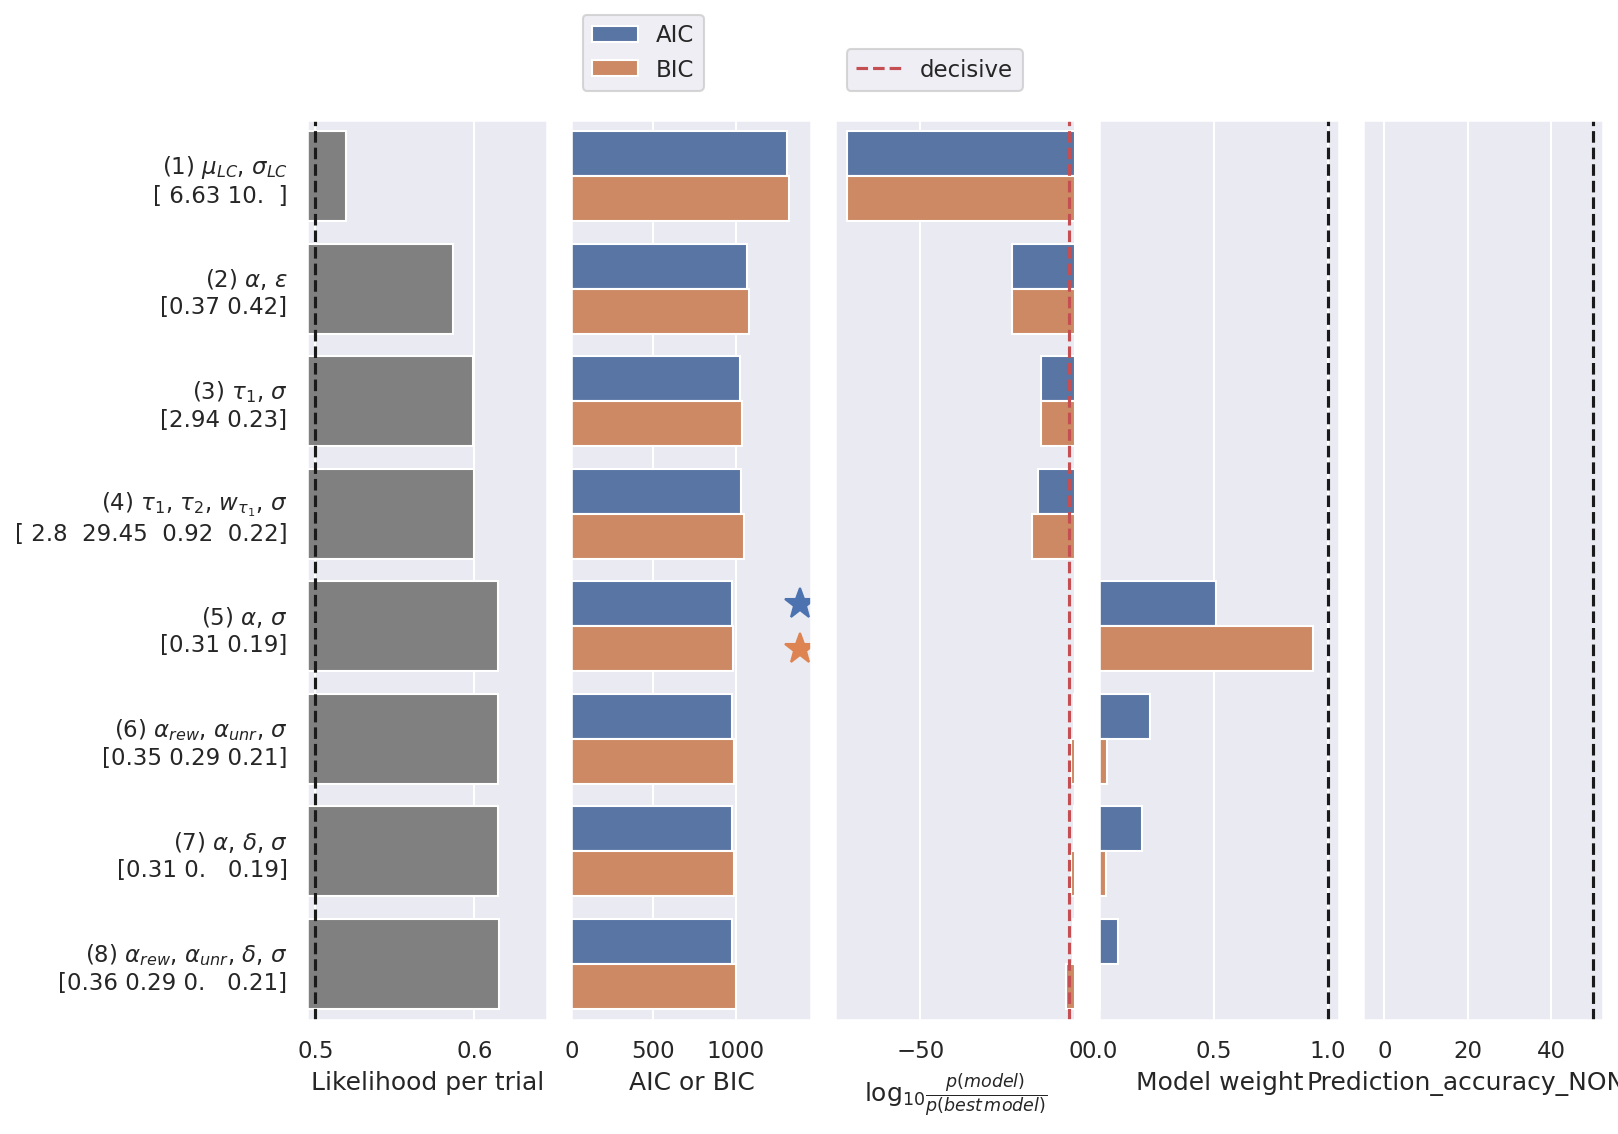

In [29]:
model_comparison.show()
model_comparison.plot()

# References

[Wilson, Collins, Elife, 2019] ​
Ten simple rules for the computational modeling of behavioral data​


> **Reference**  
> Palminteri, S., Wyart, V., & Koechlin, É. (2017). The importance of falsification in computational cognitive modeling. *Trends in Cognitive Sciences*, 21(6), 425-433.